# Интернет-магазин "Стримчик"

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

__Цель исследования__ - проанализировать определяющие успешность игры закономерности для планирования развития и продвижения продукта.

__Ход исследования__:
1. Загрузка и предобработка данных;
2. Визуализация полученной информации;
4. Исследование каждой категории;
3. Подсчет и проверка гипотез. 


In [1717]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
import warnings
from thefuzz import process
warnings.filterwarnings("ignore")

## Загрузка данных

In [1718]:
games_df = pd.read_csv('/datasets/games.csv')
games_df

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


__Описание данных__
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы проданных копий)
* EU_sales — продажи в Европе (миллионы проданных копий)
* JP_sales — продажи в Японии (миллионы проданных копий)
* Other_sales — продажи в других странах (миллионы проданных копий)
* Critic_Score — оценка критиков (максимум 100)
* User_Score — оценка пользователей (максимум 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board)


Имеются данные мира компьютерных игр за 2016 год. Дана информация по каждой игре - платформа, год выпуска, жанр, оценка критиков. Имеются данные по продажам в Северной Америке, Европе, Японии и других странах. Так же есть оценка возрастной категории от организации ESRB. На этих данных будем проводить анализ.

## Подготовка данных

### Замена названий столбцов

Приведем названия колонок датафрейма к нижнему регистру:

In [1719]:
change_columns = list()
for column in games_df.columns:
    change_columns.append(column.lower())
games_df.columns = change_columns
games_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


### Обработка пропусков

Проверим количество пустых значений года выпуска:

In [1720]:
games_df['year_of_release'].isna().sum()

269

Удалим строки с пустыми значениями, так как их немного

In [1721]:
games_df = games_df.dropna(subset=['year_of_release'])
games_df['year_of_release'].isna().sum()

0

Проверим количество пустых значений оценки критиков:

In [1722]:
games_df['critic_score'].isna().sum()

8463

Заполним пропуски оценок критиков заглушкой - значением -1, так как оценка критиков не может быть отрицательным числом. Это понадобится для дальнейшего приведения этого столбца к целочисленному типу данных

In [1723]:
games_df['critic_score'] = games_df['critic_score'].fillna(-1)

In [1724]:
games_df['critic_score'].min(), games_df['critic_score'].max()

(-1.0, 98.0)

Видим, что значения теперь лежат в диапазоне (-1, 98). Аналогично сделаем с оценками пользователей

In [1725]:
games_df['user_score'].isna().sum()

6607

In [1726]:
games_df['user_score'] = games_df['user_score'].replace('tbd', np.nan)
games_df['user_score'] = games_df['user_score'].fillna(-1)

In [1727]:
games_df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

In [1728]:
games_df['rating'].isna().sum()

6678

Пропуски в столбце с возрастным рейтингом заполним заглушкой - значением -1:

In [1729]:
games_df['rating'] = games_df['rating'].fillna(0)

Удалим по 2 строки с пропусками в столбцах name и genre

In [1730]:
games_df[(games_df['name'].isna()) | (games_df['genre'].isna())]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,-1.0,-1,0
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,-1.0,-1,0


In [1731]:
games_df = games_df.dropna(subset=['name', 'genre'])

### Преобразование типов данных

Проверим типы данных колонок:

In [1732]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  object 
 10  rating           16444 non-null  object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Изменим типы данных в некоторых столбцах

In [1733]:
games_df['year_of_release'] = games_df['year_of_release'].astype(int)

In [1734]:
games_df['critic_score'] = games_df['critic_score'].astype(int)

In [1735]:
games_df['user_score'] = games_df['user_score'].astype(float)

Итог:

In [1736]:
games_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int64  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  int64  
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
dtypes: float64(5), int64(2), object(4)
memory usage: 1.5+ MB


__Итог:__
* В столбце year_of_release значения преобразованы в целочисленные (int64), потому что год выпуска не может быть вещественным числом. Предварительно удалены строки с пустыми значениями. Так как их 269, а общий датафрейм - более 16к строк, это не повлияет на исследование.
* В critic_score около половины значений - пропуски. Удалить половину данных не можем, поэтому заполнили заглушкой. Данные в этом столбце преобразованы в int, так как вещественных значений не было.
* В оценке пользователей так же около половины значений - пропуски, аналогично заполнены заглушкой. Столбец привели к типу данных float.
* В rating (возрастной рейтинг) так же много пустых значений, их заполним 0. Так как это не количественная оценка, а категориальная.

Заполнение "заглушкой" является хорошим вариантом, так как это поможет при дальнейшем исследовательском анализе и проверке гипотез

Причины пропусков:
* В year_of_release причиной пропусков мог стать человеческий фактор - забыли заполнить год выпуска игры. 
* В critic_score, user_score и возрастном рейтинге причиной могли стать отсутствие, недостаточность данных.
* В rating ESRB могла еще не присвоить игре подходящую возрастную категорию - отсутствие данных.

В столбце с оценкой пользователей (user_score) при заполнении пропусков появляется ошибка TypeError: could not convert string to float: 'tbd'. Она возникает, когда метод fillna() не может интерпретировать строковое значение в числовой тип данных float. Чтобы заполнить пропуски сначала заменим эти значения на NaN.


### Колонка с общими продажами

In [1737]:
games_df['sales_all_regions'] = games_df['na_sales'] + games_df['eu_sales'] + games_df['jp_sales'] + games_df['other_sales']
games_df = games_df[games_df['sales_all_regions'] != 0] # удалим игры прибыль которых равна 0 - аномалии
games_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all_regions
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,0,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,0,31.38


### Поиск дубликатов

Попробуем удалить строки с явными дубликатами:

In [1738]:
print(games_df.shape)
games_df = games_df.drop_duplicates()
print(games_df.shape)

(16442, 12)
(16442, 12)


Как видим, явных дубликатов в датафрейме не было

Удаление неявных дубликатов:

In [1739]:
games_df['platform'].unique()
games_df.shape

(16442, 12)

In [1740]:
games_df['name'] = games_df['name'].str.lower()
games_df = games_df.drop_duplicates(subset=['name', 'platform', 'year_of_release'])
games_df.shape

(16441, 12)

Итог: проверены и удалены дубликаты

### Вывод

* Названия столбцов приведены к нижнему регистру
* Удалены игры с отсутствием годы релиза
* Оценки критиков и пользователей, возрастной рейтинг заполнены заглушками
* Столбцы с оценками и годом приведены к числовому типу данных
* Удалено незначительное количество данных с пустым и значениями в других столбцах
* Добавлена колонка с общими продажами по всем регионам
* Данные проверены на дубликаты

## Исследовательский анализ данных

### Количество игр за все годы

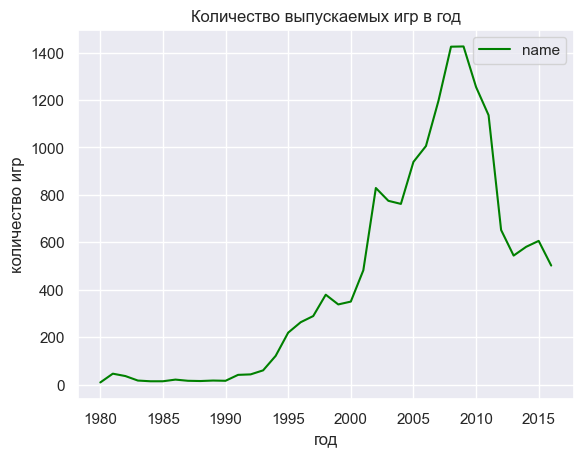

In [1741]:
games_df.pivot_table(index='year_of_release', values='name', aggfunc='count').plot(color='green')
plt.title('Количество выпускаемых игр в год')
plt.xlabel('год')
plt.ylabel('количество игр')
plt.show()

Наибольшое количество игр выпустили за 2007-2011 годы. В 2016 состоялся релиз около 500 игр и это немного меньше, чем за предыдущие годы. При этом за последние годы (2013-2016) можно заметить тенденцию значительного спада релизов. Так же смотря на график понимаем, что данные за все периоды неважны, так как ранее 1995 года выпуслось незначительно мало игр на фоне текущего количества.

__Вывод__
* Посмотрели количество выпускаемых игр в год
* Проанализировали важность данных за все периоды

### Изменение продаж по платформам

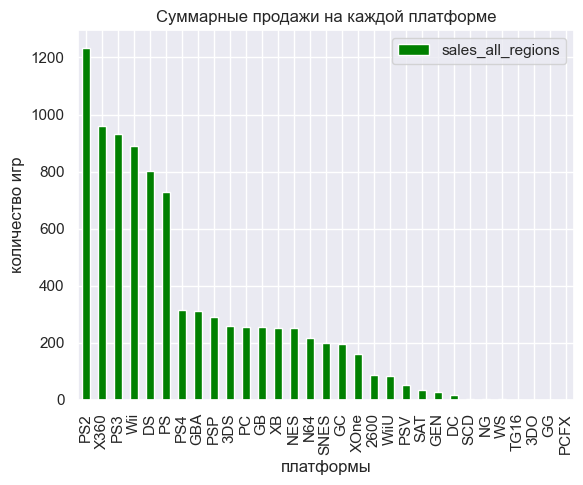

In [1742]:
sales_by_platform = games_df.pivot_table(index='platform', values='sales_all_regions', aggfunc='sum')
sales_by_platform = sales_by_platform.sort_values(by='sales_all_regions', ascending=False)
sales_by_platform.plot(kind='bar', color='green')
plt.title('Суммарные продажи на каждой платформе')
plt.xlabel('платформы')
plt.ylabel('количество игр')
plt.show()

In [1743]:
sales_by_platform_best = sales_by_platform.sort_values(by='sales_all_regions', ascending=False)[:5]
sales_by_platform_best

,sales_all_regions
platform,
PS2,1233.56
X360,961.24
PS3,931.33
Wii,891.18
DS,802.78


Платформы с наибольшими суммарными продажами - DS, PS2, PS3, Wii, X360. Построим для них распределение по годам:

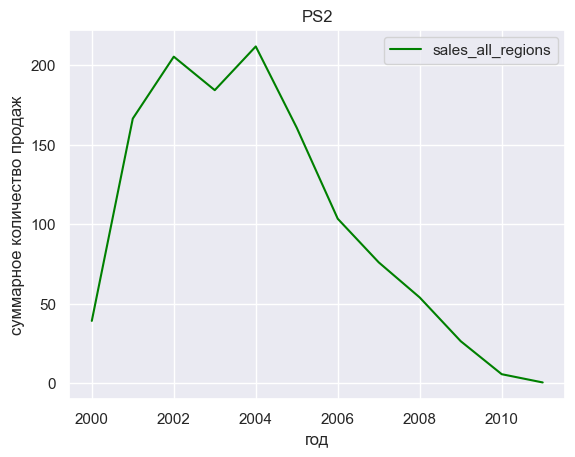

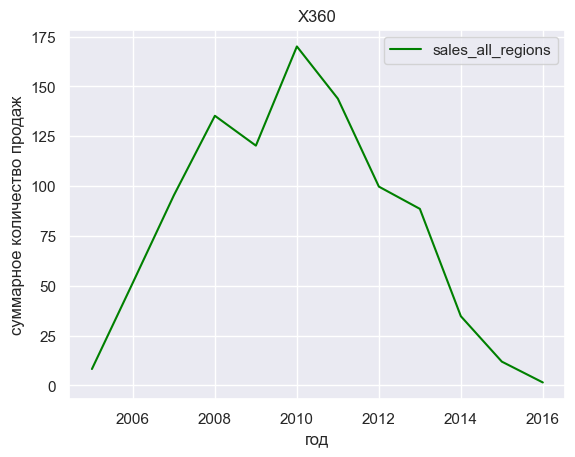

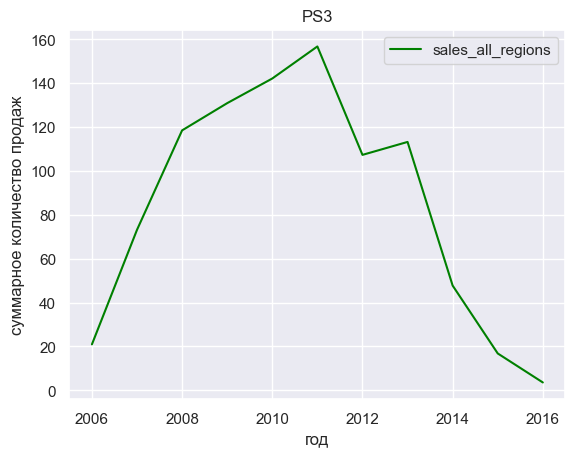

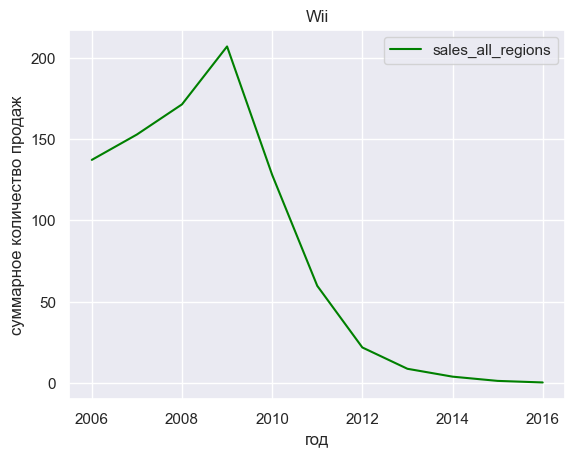

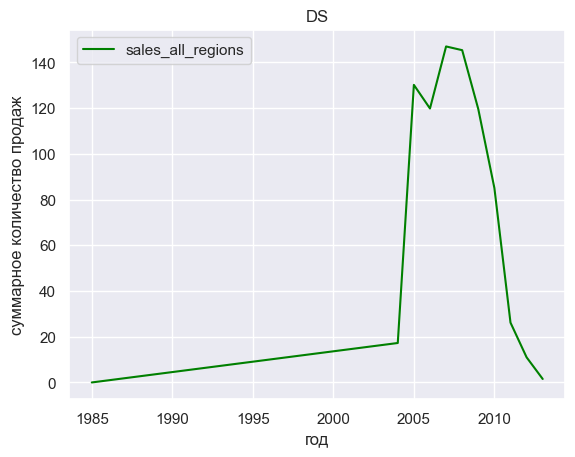

In [1744]:
for platform in sales_by_platform_best.index:
    games_df[games_df['platform'] == platform].pivot_table(index='year_of_release', values='sales_all_regions', aggfunc='sum').plot(color='green')
    plt.title(f'{platform}')
    plt.xlabel('год')
    plt.ylabel('суммарное количество продаж')

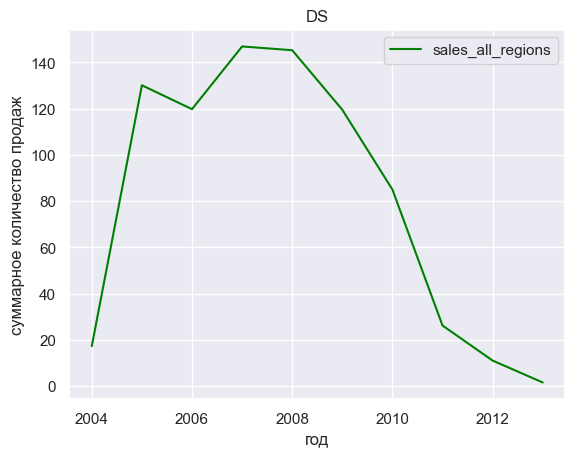

In [1745]:
games_df[games_df['platform'] == 'DS'].pivot_table(index='year_of_release', values='sales_all_regions', aggfunc='sum').query('year_of_release != 1985').plot(color='green')
plt.title('DS')
plt.xlabel('год')
plt.ylabel('суммарное количество продаж')
plt.show()

In [1746]:
games_df.pivot_table(index='year_of_release', values='sales_all_regions', aggfunc='sum')

,sales_all_regions
year_of_release,
1980,11.38
1981,35.68
1982,28.88
1983,16.80
1984,50.35
1985,53.95
1986,37.08
1987,21.70
1988,47.21


In [1747]:
# Комментарий ревьюера
temp = games_df.copy() 
time_life = temp.pivot_table(index='platform', values='year_of_release', aggfunc=['min', 'max']).reset_index()
time_life.columns = ['platform', 'min_year_of_release', 'max_year_of_release'] 
time_life = time_life.query('min_year_of_release > 1980').query('max_year_of_release < 2016')
time_life['life'] = time_life['max_year_of_release'] - time_life['min_year_of_release'] + 1 # в срок жизни платформы, должны входить границы диапазона, 
                                                            # поэтому +1
time_life['life'].median()


7.0

__Вывод__
* Определены платформы с наибольшими суммарными продажами - DS, PS2, PS3, Wii, X360

* Построены распределения продаж по годам - посмотрели за какое характерное время исчезают платформы

* Удалены платформы, которые приходятся на крайние значения датасета (они могут существовать за границами таблицы). Посчитав медиану по данным за весь период, получаем, что платформы исчезают примерно за 7 лет

### Актуальные данные

Для того, чтобы проводить дальнейшие исследования - определять лидирующие платформы по продажам, глобальные продажи игр, распределение по жанрам. Возьмем актуальные данные за последние 3 года, так как это наиболее оптимальный период для точных прогнозов

Создадим новый датафрейм, в котором будут хранится только данные за последние 3 года 

In [1748]:
games_df_actual = games_df[games_df['year_of_release'] >= 2014] # 3 года - 2014, 2015, 2016

### Лидирующие платформы по продажам

Выясним потенциально прибыльные платформы за последние годы, определим какие платформы растут и падают с точки зрения продаж

Создадим сводную таблицу по суммарным продажам на платформах

In [1749]:
actual_sales_by_platform = games_df_actual.pivot_table(index='platform', values='sales_all_regions', aggfunc='sum')
actual_sales_by_platform_best = actual_sales_by_platform.sort_values(by='sales_all_regions', ascending=False)[:5]
actual_sales_by_platform_best

,sales_all_regions
platform,
PS4,288.15
XOne,140.36
3DS,86.68
PS3,68.18
X360,48.22


__Вывод__: 

Потенциально прибыльные платформы за последние 3 года (на момент 2016 года):
* PS4
* XOne
* 3DS	
* PS3	
* X360

### Глобальные продажи игр по платформам

Сгруппируем датафрейм актуальных платформ и построем графики "ящики с усами" на одной плоскости, чтобы посмотреть на глобальные продажи игр по платформам

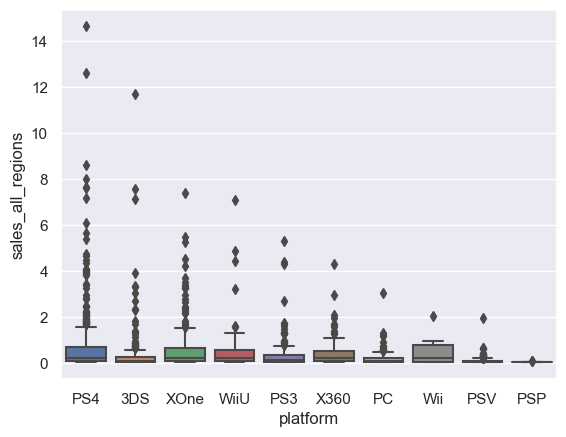

In [1750]:
sns.boxplot(x='platform', y='sales_all_regions', data=games_df_actual) 
ax.set(xlabel='платформа', ylabel='прибыль')
plt.show()

Изменим масштаб:

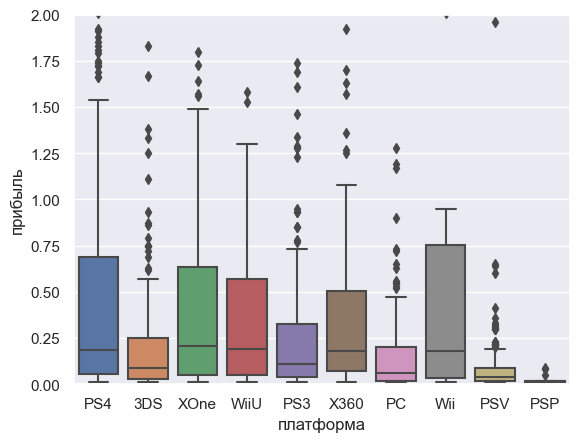

In [1751]:
ax = sns.boxplot(x='platform', y='sales_all_regions', data=games_df_actual) 
ax.set_ylim(bottom=0, top=2)
ax.set(xlabel='платформа', ylabel='прибыль')
plt.show()

Вспомогательные уточнения для вывода:

In [1752]:
games_df_actual[games_df_actual['sales_all_regions'] == games_df_actual['sales_all_regions'].max()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all_regions
31,call of duty: black ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,0,14.63


In [1753]:
games_df_actual[games_df_actual['sales_all_regions'] == 0.01]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all_regions
15486,arslan: the warriors of legend,XOne,2016,Action,0.01,0.00,0.00,0.0,-1,5.8,T,0.01
15597,ratchet & clank collection,PSV,2014,Action,0.00,0.01,0.00,0.0,-1,-1.0,0,0.01
15734,prototype: biohazard bundle,PS4,2016,Action,0.01,0.00,0.00,0.0,48,2.0,M,0.01
15762,rabbids invasion: the interactive tv show,PS4,2014,Misc,0.00,0.01,0.00,0.0,-1,-1.0,0,0.01
15790,this war of mine,PS4,2016,Action,0.00,0.01,0.00,0.0,-1,-1.0,0,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,strawberry nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.0,-1,-1.0,0,0.01
16707,aiyoku no eustia,PSV,2014,Misc,0.00,0.00,0.01,0.0,-1,-1.0,0,0.01
16710,samurai warriors: sanada maru,PS3,2016,Action,0.00,0.00,0.01,0.0,-1,-1.0,0,0.01
16712,haitaka no psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.0,-1,-1.0,0,0.01


__Вывод:__

Можно заметить, что тенденция продаж по платформам примерно одинаковая - большинство игр в среднем приносят 250 тысяч долларов, выбросы составляют единичные случаи, когда игра становится очень популярной и приносит гораздо больше.

Можно сделать несколько выводов:
* Самая продаваемая игра за последние 3 года выпускалась на PS4 - Call of duty: black ops 3, принесла более 14 млн долларов;
* Наибольшую среднюю прибыль (по медиане) приносят игры на платформе PS4 и XOne; 
* Наибольший разброс прибыли с игр на платформе Wii; 
* Много игр, не зависимо от платформы, имеют наименьшее значение прибыли - 10к долларов.

### Влияние отзывов на продажи (PS4)

Посмотрим, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков на примере PS4:

                   critic_score  sales_all_regions
critic_score           1.000000           0.402661
sales_all_regions      0.402661           1.000000


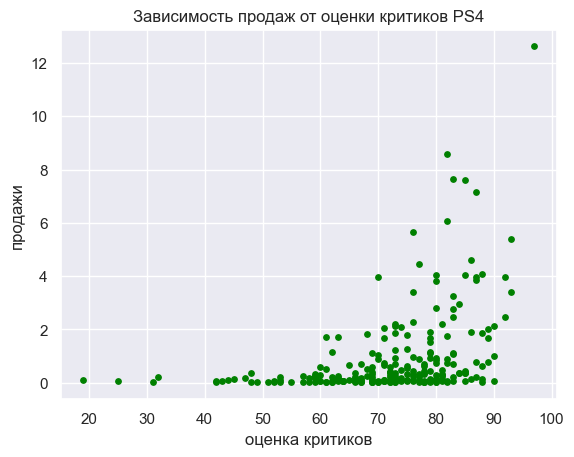

In [1754]:
games_df_PS4 = games_df_actual[games_df_actual['platform'] == 'PS4']
games_df_PS4 = games_df_PS4.query('critic_score != -1') # отфильтруем заглушки 
plt.scatter(games_df_PS4['critic_score'], games_df_PS4['sales_all_regions'], color='green', s=15)
print(games_df_PS4[['critic_score', 'sales_all_regions']].corr())
plt.title('Зависимость продаж от оценки критиков PS4')
plt.xlabel('оценка критиков')
plt.ylabel('продажи')
plt.show()

                   user_score  sales_all_regions
user_score           1.000000          -0.005041
sales_all_regions   -0.005041           1.000000


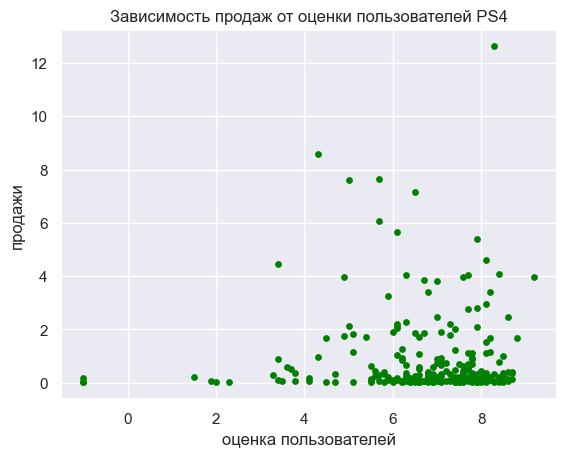

In [1755]:
plt.scatter(games_df_PS4['user_score'], games_df_PS4['sales_all_regions'], color='green', s=15)
print(games_df_PS4[['user_score', 'sales_all_regions']].corr())
plt.title('Зависимость продаж от оценки пользователей PS4')
plt.xlabel('оценка пользователей')
plt.ylabel('продажи')
plt.show()

Можно сделать вывод, что отзывы пользователей почти не влияют на прибыль от игры, оценки критиков влияют гораздо сильнее с коэффициентом корреляции 0.4

              critic_score  user_score
critic_score      1.000000    0.478431
user_score        0.478431    1.000000


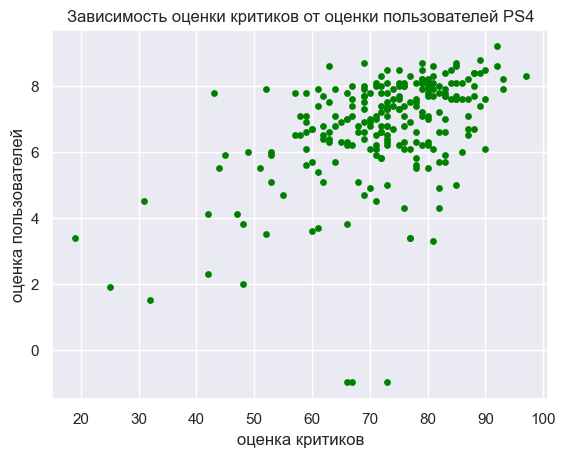

In [1756]:
plt.scatter(games_df_PS4['critic_score'], games_df_PS4['user_score'], color='green', s=15)
print(games_df_PS4[['critic_score', 'user_score']].corr())
plt.title('Зависимость оценки критиков от оценки пользователей PS4')
plt.xlabel('оценка критиков')
plt.ylabel('оценка пользователей')
plt.show()

Однако можем заметить почти линейную зависимость оценки критиков от оценки пользователей, коэффициент корреляции - 0.48

__Вывод:__
* оценка критиков сильно влияет на продажи *на платформе PS4*

* оценка пользователей не влияет на продажи *на платформе PS4*

* оценка критиков и оценка пользователей - зависимые величины на *платформе PS4*

### Влияние отзывов на продажи (сравнение с другими платформами)

Все актуальные платформы (удалим Wii и PSP, так как у их игр нет положительных оценок за текущий период, платформы вымерли):

In [1757]:
platforms_actual = list(games_df_actual['platform'].unique())
platforms_actual.remove('Wii')
platforms_actual.remove('PSP')
platforms_actual

['PS4', '3DS', 'XOne', 'WiiU', 'PS3', 'X360', 'PC', 'PSV']

Соотнесем выводы из предыдущего пункта с влиянием на продажи оценок на других популярных платформах - '3DS', 'XOne', 'WiiU', 'PS3', 'X360', 'PC' 'PSV'.

Платформа - 3DS
                   critic_score  sales_all_regions
critic_score           1.000000           0.284686
sales_all_regions      0.284686           1.000000


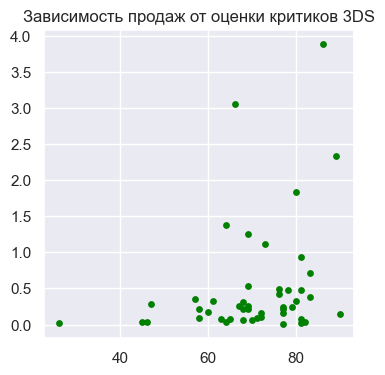

                   user_score  sales_all_regions
user_score            1.00000            0.27985
sales_all_regions     0.27985            1.00000


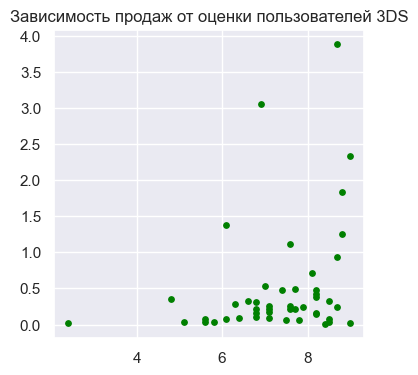

Платформа - XOne
                   critic_score  sales_all_regions
critic_score           1.000000           0.422112
sales_all_regions      0.422112           1.000000


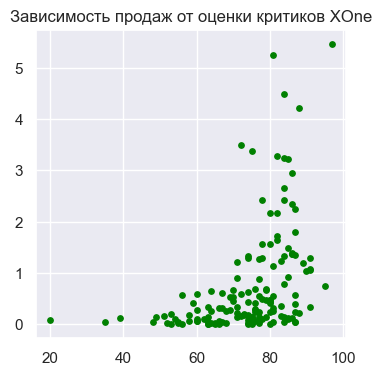

                   user_score  sales_all_regions
user_score           1.000000          -0.091734
sales_all_regions   -0.091734           1.000000


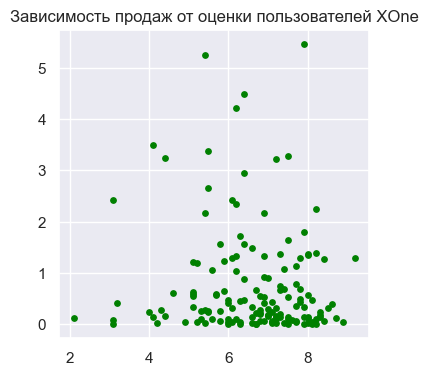

Платформа - WiiU
                   critic_score  sales_all_regions
critic_score            1.00000            0.37564
sales_all_regions       0.37564            1.00000


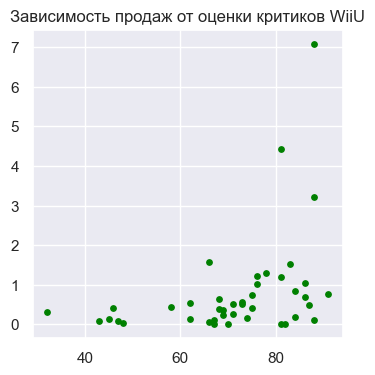

                   user_score  sales_all_regions
user_score           1.000000           0.411451
sales_all_regions    0.411451           1.000000


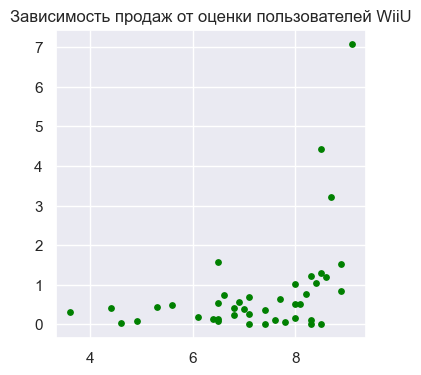

Платформа - PS3
                   critic_score  sales_all_regions
critic_score           1.000000           0.446575
sales_all_regions      0.446575           1.000000


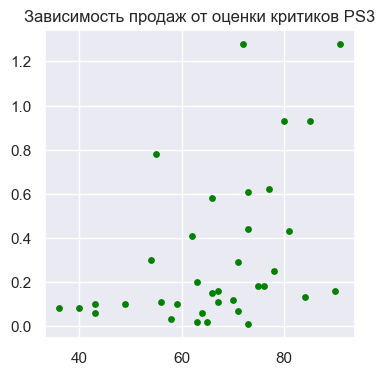

                   user_score  sales_all_regions
user_score           1.000000           0.156595
sales_all_regions    0.156595           1.000000


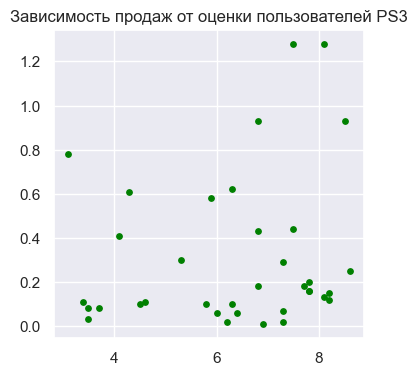

Платформа - X360
                   critic_score  sales_all_regions
critic_score           1.000000           0.525723
sales_all_regions      0.525723           1.000000


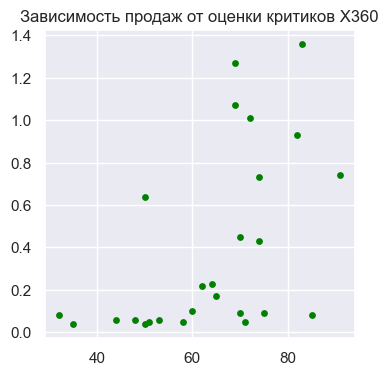

                   user_score  sales_all_regions
user_score           1.000000           0.336514
sales_all_regions    0.336514           1.000000


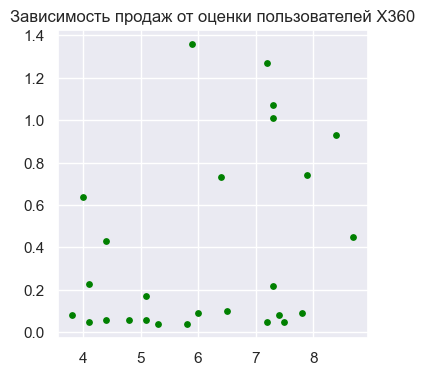

Платформа - PC
                   critic_score  sales_all_regions
critic_score           1.000000           0.172061
sales_all_regions      0.172061           1.000000


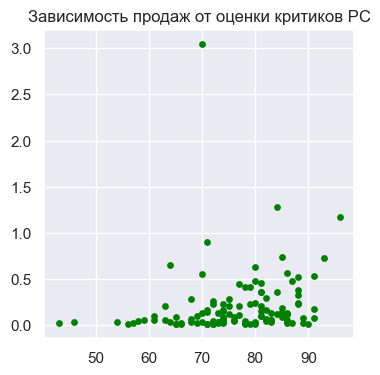

                   user_score  sales_all_regions
user_score           1.000000          -0.089974
sales_all_regions   -0.089974           1.000000


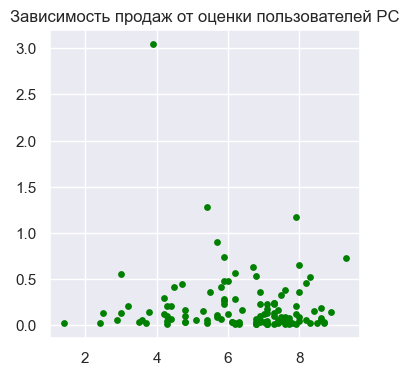

Платформа - PSV
                   critic_score  sales_all_regions
critic_score           1.000000           0.041029
sales_all_regions      0.041029           1.000000


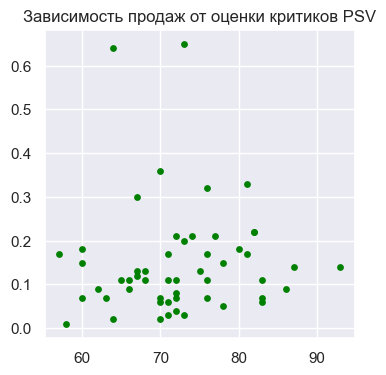

                   user_score  sales_all_regions
user_score           1.000000           0.023528
sales_all_regions    0.023528           1.000000


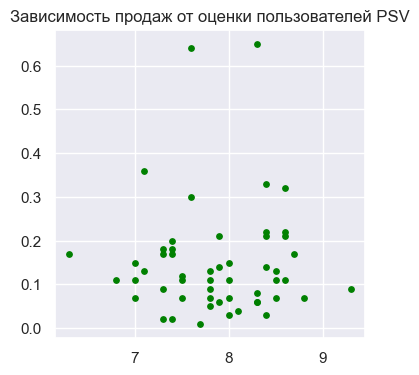

In [1758]:
for platform in platforms_actual[1:]: # список без PS4, ее рассматривали ранее
    games_df_platform = games_df_actual[games_df_actual['platform'] == platform]
    games_df_platform = games_df_platform.query('critic_score != -1')
    games_df_platform = games_df_platform.query('user_score != -1')
    print(f'Платформа - {platform}')

    plt.figure(figsize=(4, 4))
    plt.scatter(games_df_platform['critic_score'], games_df_platform['sales_all_regions'], color='green', s=15)
    print(games_df_platform[['critic_score', 'sales_all_regions']].corr())
    plt.title(f'Зависимость продаж от оценки критиков {platform}')
    plt.show()

    plt.figure(figsize=(4, 4))
    plt.scatter(games_df_platform['user_score'], games_df_platform['sales_all_regions'], color='green', s=15)
    print(games_df_platform[['user_score', 'sales_all_regions']].corr())
    plt.title(f'Зависимость продаж от оценки пользователей {platform}')
    plt.show()

__Вывод:__

Ситуация на каждой из рассматриваемых платформ примерно одинаковая - оценки критиков сильнее влияют на продажи, чем оценки пользователей. На одной из платформ (DS) оценки пользователей даже отрицательно влияют на продажи. 

Из общей закономерности можно удалить 3DS и WiiU, у них коэффициент корреляции оценок пользователей равен или больше коэффициент корреляции оценок критиков. Возможно это связано с тем, что платформы устаревают и для корректности выводов их можно удалить

### Распределение игр по жанрам

В этом разделе посмотрим распределение игр по жанрам, выделим самые популярные, прибыльные и с низкими продажами

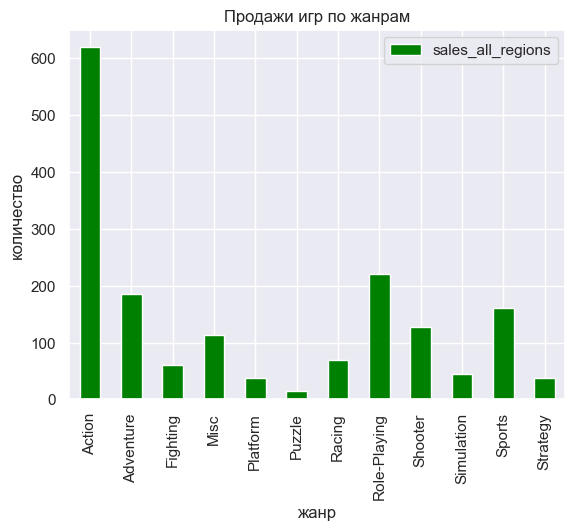

In [1759]:
games_df_actual.pivot_table(index='genre', values='sales_all_regions', aggfunc='count').plot(kind='bar', color='green')
plt.title('Продажи игр по жанрам')
plt.xlabel('жанр')
plt.ylabel('количество')
plt.show()

In [1760]:
games_df_actual.pivot_table(index='genre', values='sales_all_regions', aggfunc='count').sort_values(by='sales_all_regions', ascending=False)

,sales_all_regions
genre,
Action,619
Role-Playing,221
Adventure,185
Sports,161
Shooter,128
Misc,113
Racing,69
Fighting,60
Simulation,44


Самые популярные жанры - боевик, приключения, спортивные и ролевые игры.

Построим диаграммы размаха и по медиане определим самые прибыльные жанры:

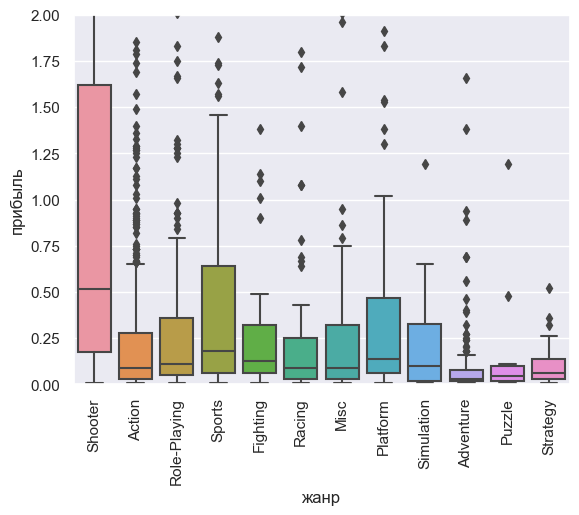

In [1761]:
ax = sns.boxplot(x='genre', y='sales_all_regions', data=games_df_actual) 
ax.set_ylim(bottom=0, top=2)
ax.set(xlabel='жанр', ylabel='прибыль')
plt.xticks(rotation=90)
plt.show()

In [1762]:
games_df_actual.pivot_table(index='genre', values='sales_all_regions', aggfunc='median').sort_values(by='sales_all_regions', ascending=False)

,sales_all_regions
genre,
Shooter,0.515
Sports,0.180
Platform,0.140
Fighting,0.125
Role-Playing,0.110
Simulation,0.100
Action,0.090
Misc,0.090
Racing,0.090


Самые прибыльные жанры  - шутеры, платформеры, спортивные игры, файтинг. Самые низкие продажи у игр в жанрах приключений, стратегии, головоломок.

In [1763]:
games_df.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all_regions
0,wii sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,82.54
1,super mario bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1,-1.0,0,40.24
2,mario kart wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,35.52
3,wii sports resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,32.77
4,pokemon red/pokemon blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1,-1.0,0,31.38


__Вывод__: 

Самые популярные и продаваемые жанры - боевики, ролевые игры, шутеры, спортивные. Маленькой популярностью за последние 3 года (на момент 2016 г.) обладают головоломки, приключения, стратегии.

### Общий вывод

В этом пункте посмотрели за какой характерный промежуток времени исчезают платформы и выяснили несколько закономерностей за последние 3 года:
* Наибольшими суммарными продажами обладают платформы - PS4, XOne, 3DS, PS3, X360
* Наибольшую среднюю прибыль приносят игры на платформе PS4 и XOne
* Самая продаваемая игра - Call of duty: black ops 3 (14 млн долларов)
* Отзывы пользователей почти не влияют на прибыль от игры
* На продажи сильно влияют ценки критиков
* Наибольшей популярностью пользуются быстрые, динамичные игры - боевики, спорт, ролевые, шутеры
* Не пользуются особой популярностью головоломки, стратегии

## Портрет пользователя каждого региона

### NA - Nothern America

Сформируем портрет среднестатистического игрока Северной Америки:
* Топ-5 популярных платформ
* Топ-5 популярных жанров
* Влияние рейтинга ESRB

In [1764]:
games_df_na = games_df_actual.query('na_sales > 0')
games_df_na.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all_regions
31,call of duty: black ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,0,14.63
42,grand theft auto v,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
47,pokemon omega ruby/pokemon alpha sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,-1,-1.0,0,11.68
77,fifa 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
87,star wars battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,-1,-1.0,0,7.98


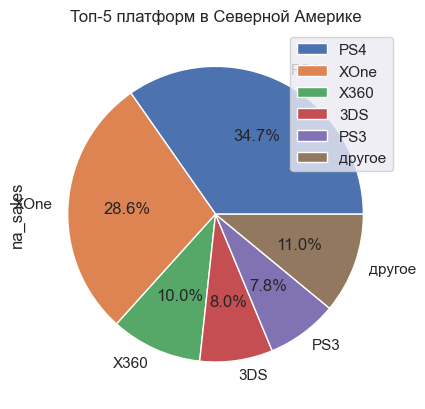

In [1765]:
popular_platforms_na = games_df_na.pivot_table(index='platform', values='na_sales', aggfunc='sum')
top_platform_na = popular_platforms_na.sort_values(by='na_sales', ascending=False)[:5]
top_platform_na.loc['другое'] = popular_platforms_na['na_sales'].sum() - top_platform_na['na_sales'].sum()
top_platform_na.plot.pie(subplots=True, autopct='%1.1f%%')
plt.title('Топ-5 платформ в Северной Америке')
plt.show()

Топ-5 популярных платформ в Америке - PS4, XOne, X360, 3DS, PS3. Первые два места по продажам занимают PS4 и XOne - последние модели консолей от Sony и Microsoft. Гораздо меньшей популярностью пользуются остальные платформы

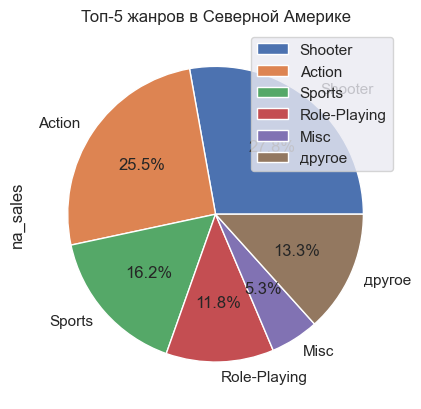

In [1766]:
popular_genre_na = games_df_na.pivot_table(index='genre', values='na_sales', aggfunc='sum')
top_genre_na = popular_genre_na.sort_values(by='na_sales', ascending=False)[:5]
top_genre_na.loc['другое'] = popular_genre_na['na_sales'].sum() - top_genre_na['na_sales'].sum()
top_genre_na.plot.pie(subplots=True, autopct='%1.1f%%')
plt.title('Топ-5 жанров в Северной Америке')
plt.show()

В Северной Америке так же, как и на мировом рынке наибольшей популярностью пользуются боевики, шутеры, игры про спорт

Так как на моменте предобработки данных ставили заглушки, перед построением диаграммы и анализом стоит их убрать:

In [1767]:
games_df_na = games_df_na.query('rating != 0')

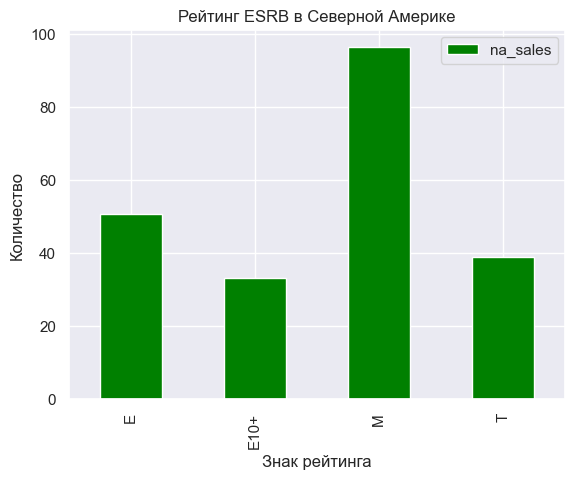

In [1768]:
rating_na = games_df_na.pivot_table(index='rating', values='na_sales', aggfunc='sum')
rating_na.plot(kind='bar', color='green')
plt.title('Рейтинг ESRB в Северной Америке')
plt.xlabel('Знак рейтинга')
plt.ylabel('Количество')
plt.show()

Видим, что наибольшую популярность в Америке имеют игры для взрослых (17+). Можно предположить, что наибольшая доля игроков в таком случае, подростки старше 17 лет.

### EU - European Union

Сформируем портрет среднестатистического игрока Европы:
* Топ-5 популярных платформ
* Топ-5 популярных жанров
* Влияние рейтинга ESRB

In [1769]:
games_df_eu = games_df_actual.query('eu_sales > 0')
games_df_eu.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all_regions
31,call of duty: black ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,0,14.63
42,grand theft auto v,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
47,pokemon omega ruby/pokemon alpha sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,-1,-1.0,0,11.68
77,fifa 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
87,star wars battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,-1,-1.0,0,7.98


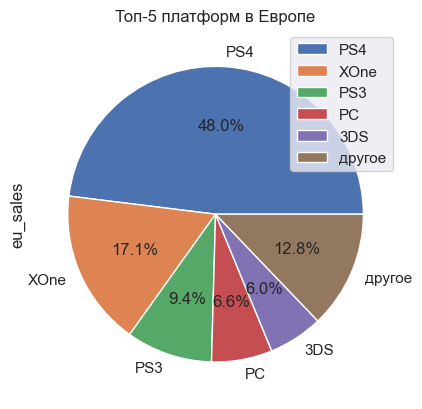

In [1770]:
popular_platforms_eu = games_df_eu.pivot_table(index='platform', values='eu_sales', aggfunc='sum')
top_platform_eu = popular_platforms_eu.sort_values(by='eu_sales', ascending=False)[:5]
top_platform_eu.loc['другое'] = popular_platforms_eu['eu_sales'].sum() - top_platform_eu['eu_sales'].sum()
top_platform_eu.plot.pie(subplots=True, autopct='%1.1f%%')
plt.title('Топ-5 платформ в Европе')
plt.show()

В Европе первое место по популярности платформ занимает PS4, с больши отрывом (почти в 3 раза) даже, чем XOne, который в Америке находится с ней практически наравных. Третье место занимает так же предыдущая консоль от Sony - PS3

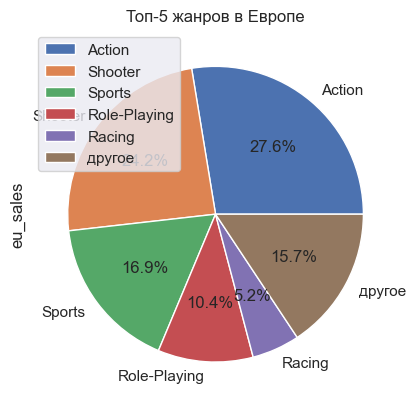

In [1771]:
popular_genre_eu = games_df_eu.pivot_table(index='genre', values='eu_sales', aggfunc='sum')
top_genre_eu = popular_genre_eu.sort_values(by='eu_sales', ascending=False)[:5]
top_genre_eu.loc['другое'] = popular_genre_eu['eu_sales'].sum() - top_genre_eu['eu_sales'].sum()
top_genre_eu.plot.pie(subplots=True, autopct='%1.1f%%')
plt.title('Топ-5 жанров в Европе')
plt.show()

В Европе тенденция по жанрам аналогично с Америкой сильно совпадает с мировым рынком. Наибольшая популярность - боевики. В отличие от Северной Америки в рейтинге присутствуют гонки.

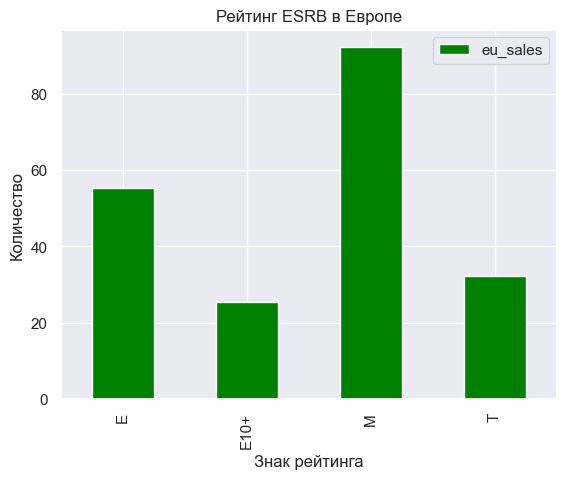

In [1772]:
games_df_eu = games_df_eu.query('rating != 0')
rating_eu = games_df_na.pivot_table(index='rating', values='eu_sales', aggfunc='sum')
rating_eu.plot(kind='bar', color='green')
plt.title('Рейтинг ESRB в Европе')
plt.xlabel('Знак рейтинга')
plt.ylabel('Количество')
plt.show()

В Европе целевая аудитория игр сильно схожа с Америкой - игры общих возрастов и 17+ 

### JP - Japan

In [1773]:
games_df_jp = games_df_actual.query('jp_sales > 0')
games_df_jp.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all_regions
31,call of duty: black ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,0,14.63
42,grand theft auto v,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
47,pokemon omega ruby/pokemon alpha sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,-1,-1.0,0,11.68
77,fifa 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
87,star wars battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,-1,-1.0,0,7.98


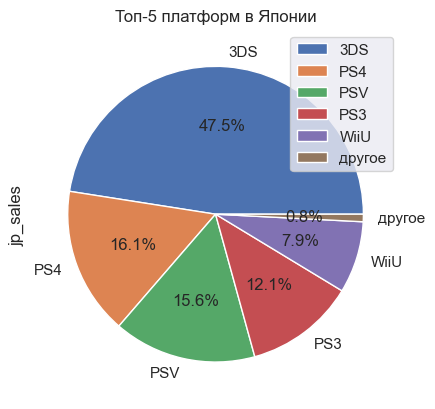

In [1774]:
popular_platforms_jp = games_df_jp.pivot_table(index='platform', values='jp_sales', aggfunc='sum')
top_platform_jp = popular_platforms_jp.sort_values(by='jp_sales', ascending=False)[:5]
top_platform_jp.loc['другое'] = popular_platforms_jp['jp_sales'].sum() - top_platform_jp['jp_sales'].sum()
top_platform_jp.plot.pie(subplots=True, autopct='%1.1f%%')
plt.title('Топ-5 платформ в Японии')
plt.show()

Лидеры рынка платформ в Японии довольно сильно отличаются от мирового и выше рассмотренных регионов. Преобладают игры на платформах японского производства, компании Nintendo. Так же в топе находиятся консоли от Sony - ps4, ps3

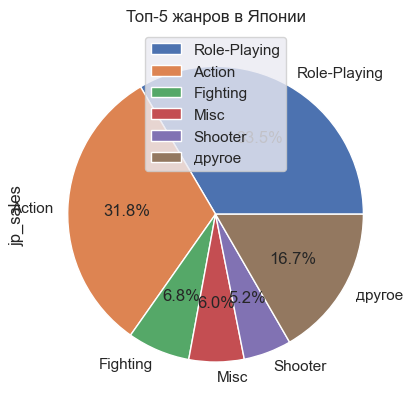

In [1775]:
popular_genre_jp = games_df_jp.pivot_table(index='genre', values='jp_sales', aggfunc='sum')
top_genre_jp = popular_genre_jp.sort_values(by='jp_sales', ascending=False)[:5]
top_genre_jp.loc['другое'] = popular_genre_jp['jp_sales'].sum() - top_genre_jp['jp_sales'].sum()
top_genre_jp.plot.pie(subplots=True, autopct='%1.1f%%')
plt.title('Топ-5 жанров в Японии')
plt.show()

В Японии с большим отрывом преобладают игры ролевого характера. Боевики, которые являются лидерами на мировом и региональных рынках в Японии находятся на втором месте. Как итог, преобладающие жанры в Японии отличаются от жанров на других рынках

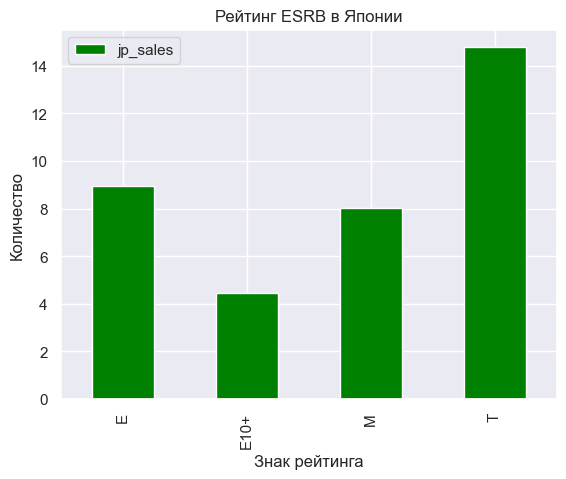

In [1776]:
games_df_jp = games_df_jp.query('rating != 0')
rating_jp = games_df_jp.pivot_table(index='rating', values='jp_sales', aggfunc='sum')
rating_jp.plot(kind='bar', color='green')
plt.title('Рейтинг ESRB в Японии')
plt.xlabel('Знак рейтинга')
plt.ylabel('Количество')
plt.show()

Можно заметить, что в Японии наиболее частыми аналогично являются игры для подростков. Можно сделать вывод, что основная аудитория игр Японии - 13+ лет.

In [1777]:
# Комментарий ревьюера
temp = games_df_actual.copy()
print(temp.rating.isna().sum(), temp.rating.isna().sum()/len(temp))
temp.rating.value_counts(dropna=False)

0 0.0


rating
0       749
T       271
M       265
E       219
E10+    185
Name: count, dtype: int64

### Общий вывод

В Северной Америке преобладают платформы американского происхождения, распределение жанров примерно совпадает с ситуацией на мировом рынке. Целевая аудитория - 17+

В Европе предпочитают приставки от компании Sony. Жанры схожи с мировым рынком, однако вместо ролевых игр преобладают гонки. Целевая аудитори - 17+, игр с высоким возрастным ограничением покупают больше, чем в Америке

В Японии рынок платформ сильно отличается - преобладает собственная компания Nintendo, в топе портативная консоль от Sony - psp. Целевая аудитори - 13+

## Проверка гипотез

In [1778]:
games_df_actual

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sales_all_regions
31,call of duty: black ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1,-1.0,0,14.63
42,grand theft auto v,PS4,2014,Action,3.96,6.31,0.38,1.97,97,8.3,M,12.62
47,pokemon omega ruby/pokemon alpha sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,-1,-1.0,0,11.68
77,fifa 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82,4.3,E,8.58
87,star wars battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,-1,-1.0,0,7.98
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,strawberry nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1,-1.0,0,0.01
16707,aiyoku no eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,-1,-1.0,0,0.01
16710,samurai warriors: sanada maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1,-1.0,0,0.01
16712,haitaka no psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1,-1.0,0,0.01


__Гипотеза - средние пользовательские рейтинги платформ Xbox One и PC одинаковые__

Нулевая гипотеза: средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Альтернативная гипотеза: средние пользовательские рейтинги платформ Xbox One и PC разные

In [1779]:
user_score_XOne = list(games_df_actual.query('platform == "XOne"').query('user_score != -1')['user_score'])
user_score_PC  = list(games_df_actual.query('platform == "PC"').query('user_score != -1')['user_score'])

alpha = 0.05
results = st.ttest_ind(user_score_XOne, user_score_PC)

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 0.10450507919348415
Не получилось отвергнуть нулевую гипотезу


In [1780]:
games_df_actual.query('platform == "XOne"').query('user_score != -1')['user_score'].mean()

6.594545454545456

In [1781]:
games_df_actual.query('platform == "PC"').query('user_score != -1')['user_score'].mean()

6.298360655737705

Применив метод .mean() понимаем, что это результат гипотез не противоречит реальности 

В результате гипотезу отвергнуть не удалось - то есть вполне возможно средние пользовательские рейтинги платформ Xbox One и PC одинаковые (но вероятно и обратное)

Критерий - уровень статистической значимости = 0.05

__Гипотеза - средние пользовательские рейтинги жанров Action и Sports разные__

Нулевая гипотеза: средние пользовательские рейтинги жанров Action и Sports одинаковые

Альтернативная гипотеза: средние пользовательские рейтинги жанров Action и Sports разные

In [1782]:
user_score_action = list(games_df_actual.query('genre == "Action"').query('user_score != -1')['user_score'])
user_score_sports  = list(games_df_actual.query('genre == "Sports"').query('user_score != -1')['user_score'])

alpha = 0.05
results = st.ttest_ind(user_score_action, user_score_sports)

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 2.8711147985105864e-19
Отвергаем нулевую гипотезу


В ходе проверки кодом предполагали, что рейтинги одинаковые и отвергли гипотезу. Следовательно, пользовательские рейтинги жанров Action и Sports разные - подтвердили гипотезу


In [1783]:
games_df_actual.query('genre == "Action"').query('user_score != -1')['user_score'].mean()

6.760606060606061

In [1784]:
games_df_actual.query('genre == "Sports"').query('user_score != -1')['user_score'].mean()

5.2251968503937

Проверим методом .mean() - результат не противоречит проверке гипотез, рейтинги пользователей действительно разные

### Вывод (ответы на вопросы)

__Принцип формулирования нулевой гипотезы__

Нулевая гипотеза формулируется так, чтобы описать ситуацию, когда не существует изменений или различий между группами. Например, "средние значения двух групп равны"

__Принцип формулирования альтернативной гипотезы__

Альтернативная гипотеза - гипотеза, которая предполагает наличие эффекта или различия. Например, "среднее значение первой группы больше среднего значения второй группы". Альтернативная гипотеза должна противоречить нулевой

__Применение t-критерия при тестировании гипотез:__
* сравнение средних значений одной выборки с известным значением
* сравнение средних значений двух независимых выборок
* сравнение средних значений двух связанных выборок

В нашем случае применяем t-критерий, так как два раза сравниваем независимые выборки

## Итоговый вывод

### Описание данных

У нас есть данные из игровой индустрии, начиная с 1985 года. Дана информация по каждой игре - название, платформа, год выпуска, возрастной рейтинг. Так же имеется информация по прибыли в регионах (Северная Америка, Европа, Япония) и об отзывах - оценках пользователей и критиков.

### Предобработка данных

В ходе подготовки данных поработали с пропусками - заменили заглушками, удалили там, где возможно. Так же преобразовали нужные колонки к числовому типу (int или float), добавили новую колонку - сумму прибыль с всех продаж по миру. Касательно дубликатов данные являются почти чистыми - удалено всего несколько значений. Есть много дубликатов названий, но они отличаются по годам выпуска и платформам 

### Исследовательский анализ

Изначально была дана информация начиная с 1980 года - такие данные мало пригождаются, если речь идет о бизнес-прогнозах на следующий год. Поэтому в ходе было решено использовать данные за последние 3 года. Однако было выяснено, что максимальные суммы продаж игр были на платформах PS2, PS3, X360. Так же был установлен срок исчезновения старых и появления новых платформ - примерно 7 лет. Были выяснены потенциально прибыльные платформы за последние 3 года - PS4, XOne, 3DS, PS3, X360. Самая продаваемая игра за последние 3 года выпускалась на PS4 - Call of duty: black ops 3, принесла более 14 млн долларов. Установлено, что очень мало игр приносит прибыль более 250 тыс долларов - лишь в единичных случаях она может составлять несколько млн долларов. Выяснили, что оценка критиков сильно влияет на продажи и оценка пользователей не влияет - так почти на всех платформах, за исключением исчезающих. Самые прибыльные жанры  - шутеры, платформеры, спортивные игры, файтинг. За последние годы гораздо менее популярными стали игры в жанре приключений, стратегий, головоломок. 

### Портрет пользователя Северной Америки, Европы и Японии

Наибольшую популярность в Америке и Европе имеют игры для взрослых (17+), в то время как в Японии сильно распространены игры для подростков - 13+. PS4 и XOne - лидирующие платформы в Америке и Европе, однако в Америке XOne немного отстает от PS4, в то время как в Европе PS4 занимает почти половину рынка консолей. В Японии лидером на рынке является собственная компания 3DS. В Америке и Европе так же сильно совпадают жанры игр - шутеры, боевики, игры про спорт. В Японии же доминируют ролевые игры. В целом, можно сделать вывод, что рынок Америки и Европы во многом схож между собой и с мировым (так как в основном они его и формируют)

### Проверка гипотез

В результате проверки того, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, гипотезу отвергнуть не удалось - то есть вполне возможно средние пользовательские рейтинги платформ Xbox One и PC одинаковые (но вероятно и обратное). 
В результате проверки второй гипотезы установили, что средние пользовательские рейтинги жанров Action и Sports разные.
В ходе проверки гипотез использовали критерий t-test потому, что два раза сравнивали незаыисимые выборки

### Планирование кампании на 2017 год

Чтобы спланировать кампанию на 2017 год следует учитывать ряд факторов, влияющих на продажи:
1. Платформа, поддерживающая игру
2. Жанр игры
3. Целевая аудитория (возраст)
4. Регион
5. Отзывы

В ходе исследования выяснили, что наилучшим вариантом будет рекламировать на платформах PS4, XOne, PS3 в Америке или Европе, так как они лучше всего отражают мировые тенденции. Целевой аудиторией можно считать взрослых или людей всех возрастов. Не стоит обращать внимания на отзывы пользователей, следует прислушиваться к критике. Игры лучше рекламировать динамичные, отражающие текущие интересы людей - шутеры, экшен, игры про спорт, ролевые.